<a href="https://colab.research.google.com/github/nickwan/really_basic_modeling/blob/master/really_basic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Really basic modeling  
What are some common models?  
What are some uncommon models?  
How do you set up a model?  
How do you get a model to predict stuff?  

Going to recreate this model:  
https://www.rotoworld.com/article/beyond-box-score/2019-expected-receiving-touchdowns  h/t bismo

## Load in 

In [1]:
!apt install subversion --quiet
!pip install adjustText --quiet
!pip install shap --quiet

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 59 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd6

In [2]:
import time
from joblib import dump, load
import random
import requests
import json
import datetime
import os
import re
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from adjustText import adjust_text
from tqdm.notebook import tqdm

import lightgbm as lgb 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.model_selection import KFold 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# # probably shouldn't rerun the full thing since it takes +30 mins 
st = time.time()
!svn export https://github.com/guga31bb/nflfastR-data/trunk/data "/content/drive/My Drive/nflfastR-data/data" --force --quiet
!svn export https://github.com/guga31bb/nflfastR-data/trunk/roster-data "/content/drive/My Drive/nflfastR-data/roster-data" --force --quiet
dur = time.time() - st 
print(f"1 iteration dur (s): {dur}\nETA (min): {6*round(dur/60)}")


1 iteration dur (s): 64.3489727973938
ETA (min): 6


In [4]:
data_dir = '/content/drive/My Drive/nflfastR-data'
data_files = [f'{data_dir}/data/{x}' for x in os.listdir(f"""{data_dir}/data""") if x.endswith('.parquet')]
df = pd.DataFrame()
for fn in tqdm(reversed(data_files)):
  _df = pd.read_parquet(fn)
  df= df.append(_df,ignore_index=True)
df.shape  

(996549, 322)

## Logistic regression  
Linear model. Really fast. Lots of assumptions about the data.  

Could use `statsmodel` for this too. Generally, I don't do much with strictly logistic regression.

In [115]:
df = df.loc[(df['play']==1)&(df['pass']==1)]
df['off_td'] = 0
df.loc[(df['touchdown'] == 1) & (df['td_team'] == df['posteam']),'off_td'] = 1
df.shape

(434740, 323)

In [116]:
model_feats = ['yardline_100','qtr', 'down', 'ydstogo','air_yards']
target = 'off_td' 

season_before_2019 = df.loc[df['season']<2019].dropna(subset=model_feats+[target]).copy() 
season_2019 = df.loc[df['season']==2019].dropna(subset=model_feats+[target]).copy() 

target_filter = season_2019['receiver_id'].value_counts()
target_filter = target_filter[target_filter>=50].index.values

In [117]:
season_before_2019.loc[:,model_feats].shape

(235538, 5)

In [118]:
test_data = (season_before_2019
             .loc[:,model_feats+[target]]
             .sample(frac=.2))
train_data = (season_before_2019
              .loc[~season_before_2019
                   .index
                   .isin(test_data
                         .index
                         .values),
                   model_feats+[target]])

print(f"train: {train_data.shape}\ntest: {test_data.shape}")

train: (188430, 6)
test: (47108, 6)


In [119]:
logistic_regression_model = LogisticRegression() 
logistic_regression_model.fit(train_data.loc[:,model_feats], train_data.loc[:,target]) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [120]:
test_data[f"{target}_pred"] = pd.DataFrame(logistic_regression_model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index,columns=[0,f"{target}_pred"])[f"{target}_pred"]

In [121]:
print(f"""pred acc: {accuracy_score(test_data[target],test_data[f"{target}_pred"].round(0))}""")
print(f"""naive acc: {accuracy_score(test_data[target],np.zeros(test_data[target].shape))}""")


pred acc: 0.9555914069797062
naive acc: 0.9555914069797062


count    47108.000000
mean         0.044052
std          0.088160
min          0.000005
25%          0.000521
50%          0.003243
75%          0.030031
max          0.427420
Name: off_td_pred, dtype: float64

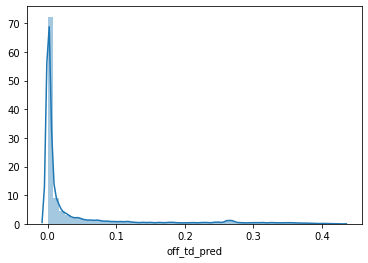

In [122]:
sns.distplot(test_data[f"{target}_pred"])
test_data[f"{target}_pred"].describe()

In [123]:
print(f"""pred log loss: {log_loss(test_data[target],test_data[f"{target}_pred"])}""")
print(f"""naive log loss: {log_loss(test_data[target],np.repeat(test_data[target].mean(),test_data[target].shape))}""")

pred log loss: 0.12151609308538575
naive log loss: 0.1817102731014873


In [124]:
kf = KFold(10, shuffle=True)
log_loss_data = [] 
acc_data = [] 

df_pred = pd.DataFrame()

for train_idx, test_idx in kf.split(season_before_2019.loc[:,model_feats+[target]]): 
  train_data = season_before_2019.iloc[train_idx] 
  test_data = season_before_2019.iloc[test_idx] 
  logistic_regression_model = LogisticRegression() 
  logistic_regression_model.fit(train_data.loc[:,model_feats], train_data.loc[:,target]) 

  test_data[f"{target}_pred"] = pd.DataFrame(logistic_regression_model
                                             .predict_proba(test_data
                                                            .loc[:,model_feats]), 
                                             index=test_data.index,
                                             columns=[0,f"{target}_pred"])[f"{target}_pred"] 
  log_loss_data.append(log_loss(test_data[target],test_data[f"{target}_pred"])) 
  acc_data.append(accuracy_score(test_data[target],test_data[f"{target}_pred"].round(0)))
  df_pred = df_pred.append(test_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

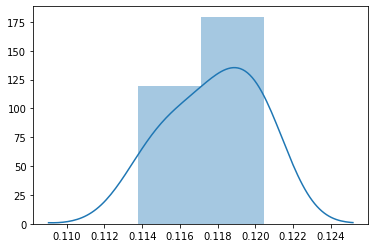

In [125]:
sns.distplot(log_loss_data)

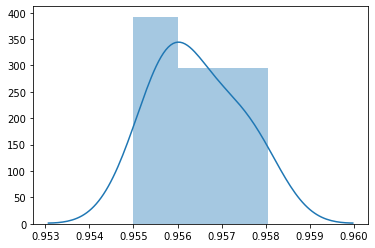

In [126]:
sns.distplot(acc_data)

In [127]:
df_pred.loc[(df['season']==2018)&(df['posteam']=='KC')&(df['receiver']=='T.Hill'),['off_td','off_td_pred']].sum()

off_td         12.000000
off_td_pred     7.894228
dtype: float64

In [128]:
logistic_regression_model = LogisticRegression() 
logistic_regression_model.fit(season_before_2019.loc[:,model_feats], season_before_2019.loc[:,target])
logistic_regression_model.fit(season_before_2019.loc[:,model_feats], season_before_2019.loc[:,target])

season_2019[f"{target}_pred"] = pd.DataFrame(logistic_regression_model
                                             .predict_proba(season_2019
                                                            .loc[:,model_feats]), 
                                             index=season_2019.index,
                                             columns=[0,f"{target}_pred"])[f"{target}_pred"] 
                                             
receiver_tds = season_2019.loc[season_2019['receiver_id'].isin(target_filter),['receiver_id','receiver','off_td','off_td_pred']].groupby(['receiver_id','receiver'],as_index=False).sum()
receiver_tds['error'] = receiver_tds['off_td'].sub(receiver_tds['off_td_pred'])                                             

In [129]:
season_2019.shape

(18442, 324)

In [130]:
season_2019.loc[season_2019['receiver_id'].isin(target_filter)].shape

(12063, 324)

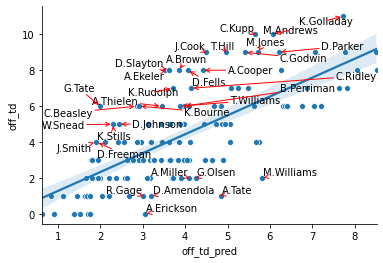

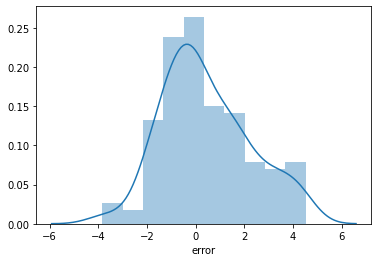

count    136.000000
mean       0.431850
std        1.811684
min       -3.842760
25%       -0.777541
50%        0.103557
75%        1.575881
max        4.505916
Name: error, dtype: float64

In [131]:
sns.regplot(x='off_td_pred', y='off_td', data=receiver_tds,scatter=False)
sns.scatterplot(x='off_td_pred', y='off_td', data=receiver_tds)
texts = [plt.text(x['off_td_pred'],x['off_td'],x['receiver']) for idx,x in receiver_tds.loc[~receiver_tds['error'].between(-2,2)].iterrows()]  
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
sns.despine()
plt.show()

sns.distplot(receiver_tds['error'])
plt.show()
receiver_tds['error'].describe()

So this ended up being alright! Logistic regression and a relatively simple feature set got us a fairly accurate replication of the rotoworld receiver TD predictions that Hayden did.  

Let's just try switching up the model and see how much more accurate (or less accurate) the predictions become.  

## Random forest  

I'm going to just take everything above and do it with the random forest stuff in `sklearn` in as few cells as possible. This is literally a 1:1 modeling attempt -- `RandomForestClassifer()` out of the box is going to be set up in the _exact same_ way as the logistic regression. `sklearn` does a really good job at model syntax for fitting and predicting.  

In [132]:
test_data = (season_before_2019
             .loc[:,model_feats+[target]]
             .sample(frac=.2))
train_data = (season_before_2019
              .loc[~season_before_2019
                   .index
                   .isin(test_data
                         .index
                         .values),
                   model_feats+[target]])

print(f"train: {train_data.shape}\ntest: {test_data.shape}")

train: (188430, 6)
test: (47108, 6)


In [133]:
rf_model = RandomForestClassifier(n_estimators=200) 
rf_model.fit(train_data.loc[:,model_feats], train_data.loc[:,target]) 
test_data[f"{target}_pred"] = pd.DataFrame(rf_model.predict_proba(test_data.loc[:,model_feats]), index=test_data.index,columns=[0,f"{target}_pred"])[f"{target}_pred"]
print(f"""pred acc: {accuracy_score(test_data[target],test_data[f"{target}_pred"].round(0))}""")
print(f"""naive acc: {accuracy_score(test_data[target],np.zeros(test_data[target].shape))}\n""")
print(f"""pred log loss: {log_loss(test_data[target],test_data[f"{target}_pred"])}""")
print(f"""naive log loss: {log_loss(test_data[target],np.repeat(test_data[target].mean(),test_data[target].shape))}""")

pred acc: 0.9503056805638108
naive acc: 0.9566315700093403

pred log loss: 0.2650255046416485
naive log loss: 0.17850527566272678


count    47108.000000
mean         0.044699
std          0.124036
min          0.000000
25%          0.000000
50%          0.000000
75%          0.005000
max          0.996818
Name: off_td_pred, dtype: float64

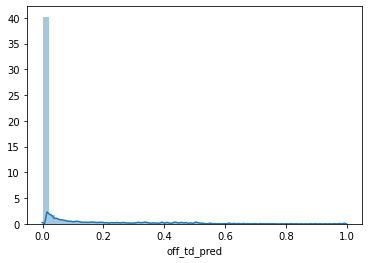

In [134]:
sns.distplot(test_data[f"{target}_pred"])
test_data[f"{target}_pred"].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

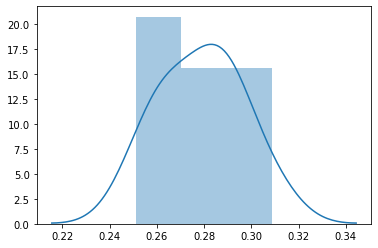

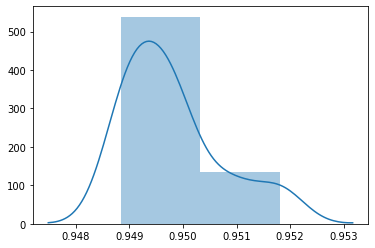

off_td         12.000000
off_td_pred    10.556582
dtype: float64

In [135]:
kf = KFold(10, shuffle=True)
log_loss_data = [] 
acc_data = [] 

df_pred = pd.DataFrame()

for train_idx, test_idx in kf.split(season_before_2019.loc[:,model_feats+[target]]): 
  train_data = season_before_2019.iloc[train_idx] 
  test_data = season_before_2019.iloc[test_idx] 
  rf_model = RandomForestClassifier(n_estimators=200) 
  rf_model.fit(train_data.loc[:,model_feats], train_data.loc[:,target]) 

  test_data[f"{target}_pred"] = pd.DataFrame(rf_model
                                             .predict_proba(test_data
                                                            .loc[:,model_feats]), 
                                             index=test_data.index,
                                             columns=[0,f"{target}_pred"])[f"{target}_pred"] 
  log_loss_data.append(log_loss(test_data[target],test_data[f"{target}_pred"])) 
  acc_data.append(accuracy_score(test_data[target],test_data[f"{target}_pred"].round(0)))
  df_pred = df_pred.append(test_data)

sns.distplot(log_loss_data)
plt.show()  

sns.distplot(acc_data)
plt.show()

df_pred.loc[(df['season']==2018)&(df['posteam']=='KC')&(df['receiver']=='T.Hill'),['off_td','off_td_pred']].sum()

In [136]:
rf_model = RandomForestClassifier(n_estimators=200) 
rf_model.fit(season_before_2019.loc[:,model_feats], season_before_2019.loc[:,target])
rf_model.fit(season_before_2019.loc[:,model_feats], season_before_2019.loc[:,target])

season_2019[f"{target}_pred"] = pd.DataFrame(rf_model
                                             .predict_proba(season_2019
                                                            .loc[:,model_feats]), 
                                             index=season_2019.index,
                                             columns=[0,f"{target}_pred"])[f"{target}_pred"] 
                                             
receiver_tds = season_2019.loc[season_2019['receiver_id'].isin(target_filter),['receiver_id','receiver','off_td','off_td_pred']].groupby(['receiver_id','receiver'],as_index=False).sum()
receiver_tds['error'] = receiver_tds['off_td'].sub(receiver_tds['off_td_pred'])                                             

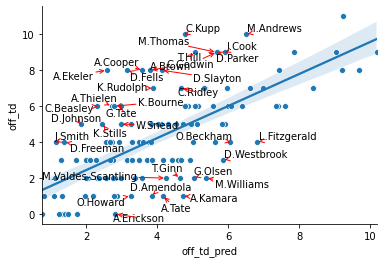

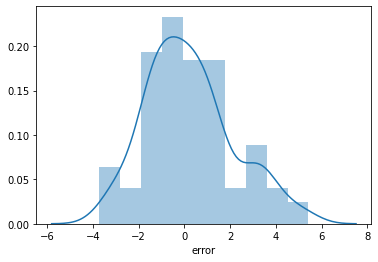

count    136.000000
mean       0.216404
std        1.920060
min       -3.722810
25%       -1.179918
50%       -0.023409
75%        1.179417
max        5.420721
Name: error, dtype: float64

In [137]:
sns.regplot(x='off_td_pred', y='off_td', data=receiver_tds,scatter=False)
sns.scatterplot(x='off_td_pred', y='off_td', data=receiver_tds)
texts = [plt.text(x['off_td_pred'],x['off_td'],x['receiver']) for idx,x in receiver_tds.loc[~receiver_tds['error'].between(-2,2)].iterrows()]  
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
sns.despine()
plt.show()

sns.distplot(receiver_tds['error'])
plt.show()
receiver_tds['error'].describe()

Random forest was not that dissimilar from the logisitc regression model. It's somewhat of the same-old-story between the two model types -- logisitc regression has less error overall, but is less accurate; random forest is more accurate overall, but has greater error when incorrect.  

The limitations of this really basic model (small feature set, large assumptions aka receiver TD probability can be inferred from air yards) is relatively known, and therefore the model differences probably aren't where someone should focus their energy if they were going to improve on these predictions. Rather, you'd probably want to figure out a better feature set or feature engineer stronger features for either model in order to gain stronger accuracy and lower loss.  

## Gradient boosted model  
Something that could deal with outliers better is a model that can handle outlier detection more elegantly. Gradient boosting does just that. `LightGBM` models are fairly popular in  Kaggle competitions when predicting rare events (see: credit card fraud detection competitions) and usually can get to an accurate prediction faster than say a well-tuned neural net. So let's just do the same things we did for the random forest and logistic regression, just in `LightGBM`.  

In [139]:
test_data = (season_before_2019
             .loc[:,model_feats+[target]]
             .sample(frac=.2))
train_data = (season_before_2019
              .loc[~season_before_2019
                   .index
                   .isin(test_data
                         .index
                         .values),
                   model_feats+[target]])

print(f"train: {train_data.shape}\ntest: {test_data.shape}")

lgb_test_data = lgb.Dataset(test_data.loc[:,model_feats], 
                            test_data.loc[:,target])

lgb_train_data = lgb.Dataset(train_data.loc[:,model_feats], 
                             train_data.loc[:,target])

lgb_season_2019 = lgb.Dataset(season_2019.loc[:,model_feats], 
                              season_2019.loc[:,target])

lgb_season_before_2019 = lgb.Dataset(season_before_2019.loc[:,model_feats], 
                                     season_before_2019.loc[:,target])


train: (188430, 6)
test: (47108, 6)


In [140]:
p = dict(
    objective='binary',
    boosting='gbdt'
  )
gb_model = lgb.train(p,train_set=lgb_train_data,valid_sets=lgb_test_data, 
                     early_stopping_rounds=300,verbose_eval=False)

In [143]:
test_data[f"{target}_pred"] = pd.Series(gb_model.predict(test_data.loc[:,model_feats]), index=test_data.index)

In [145]:
print(f"""pred acc: {accuracy_score(test_data[target],test_data[f"{target}_pred"].round(0))}""")
print(f"""naive acc: {accuracy_score(test_data[target],np.zeros(test_data[target].shape))}\n""")
print(f"""pred log loss: {log_loss(test_data[target],test_data[f"{target}_pred"])}""")
print(f"""naive log loss: {log_loss(test_data[target],np.repeat(test_data[target].mean(),test_data[target].shape))}""")

pred acc: 0.9564192918400272
naive acc: 0.9565678865585463

pred log loss: 0.11136091308294464
naive log loss: 0.17870224344536917


count    47108.000000
mean         0.042871
std          0.095451
min          0.001558
25%          0.002848
50%          0.005055
75%          0.019073
max          0.520414
Name: off_td_pred, dtype: float64

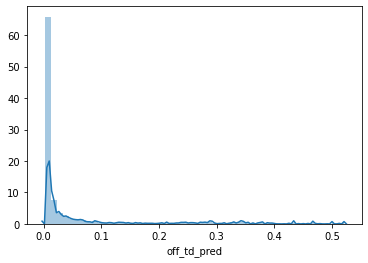

In [146]:
sns.distplot(test_data[f"{target}_pred"])
test_data[f"{target}_pred"].describe()

In [147]:
import shap 
shap.initjs()

In [148]:
shap_data = test_data.loc[:,model_feats].sample(2000)
explainer = shap.TreeExplainer(gb_model) 
shap_values = explainer.shap_values(shap_data)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


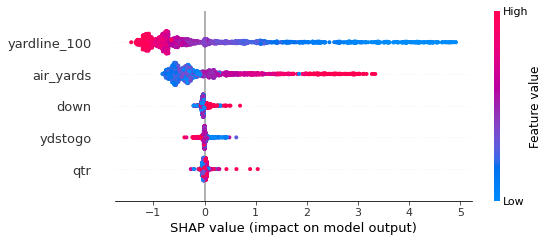

In [149]:
shap.summary_plot(shap_values[1], shap_data)

In [150]:
p = dict(
    objective='binary',
    boosting='gbdt'
  )
gb_model = lgb.train(p,train_set=lgb_season_before_2019,valid_sets=lgb_season_2019, 
                     early_stopping_rounds=300,verbose_eval=False)

season_2019[f"{target}_pred"] = pd.Series(gb_model
                                             .predict(season_2019
                                                      .loc[:,model_feats]), 
                                          index=season_2019.index)
                                             
receiver_tds = season_2019.loc[season_2019['receiver_id'].isin(target_filter),['receiver_id','receiver','off_td','off_td_pred']].groupby(['receiver_id','receiver'],as_index=False).sum()
receiver_tds['error'] = receiver_tds['off_td'].sub(receiver_tds['off_td_pred'])                                             

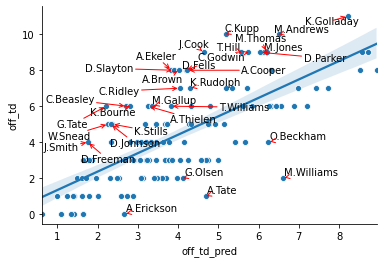

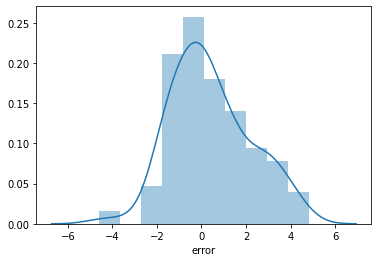

count    136.000000
mean       0.408299
std        1.791463
min       -4.599284
25%       -0.861255
50%        0.116502
75%        1.582516
max        4.813430
Name: error, dtype: float64

In [151]:
sns.regplot(x='off_td_pred', y='off_td', data=receiver_tds,scatter=False)
sns.scatterplot(x='off_td_pred', y='off_td', data=receiver_tds)
texts = [plt.text(x['off_td_pred'],x['off_td'],x['receiver']) for idx,x in receiver_tds.loc[~receiver_tds['error'].between(-2,2)].iterrows()]  
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
sns.despine()
plt.show()

sns.distplot(receiver_tds['error'])
plt.show()
receiver_tds['error'].describe()

Gradient boosting classifier out of the box was more accurate than both logistic regression and random forest. This makes a bunch of sense to me -- there are enough rare and infrequent combinations of these features that would not be optimal for either a linear model or a random forest model but would benefit from gradient boosting due to their sparse nature. This shouldn't detract from the idea that better features and more feature engineering would outperform any advanced modeling technique. A well-designed linear model would beat out this out-of-the-box simple GBM.  


## In closing  
Here are three model types using the same features and data -- ways to simply validate model performance; how to set up different train-test modeling scenarios; what a "production quality" model looks like and how to use that on a holdout dataset; some general data visualization to further elaborate on whether a model is returning realistic outputs.  

Hopefully you can use these benchmarks and model designs for your own projects!  

@nickwan 2020-06-22  